In [7]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display


In [8]:
# load the dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images.shape


(60000, 28, 28)

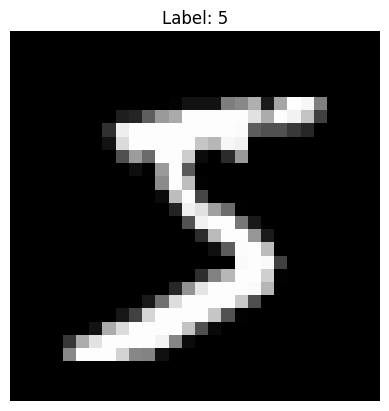

In [9]:
# Show the first image
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.axis('off')  # Hide axes
plt.show()

In [10]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  #